In [86]:
from IPython.display import Image
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import wget
import pandas as pd
import scipy.stats as stats
from scipy.stats import spearmanr
import pickle

## Search algorithm Performance: Latency

In [257]:
class ValidationCaptions:
    def __init__(self, val_captions_path):
        assert os.path.exists(val_captions_path), 'Validation file does not exist'
        with open(val_captions_path) as fd:
            validation_captions = json.load(fd)
        # id refers to the caption id
        self._data = {anno['id']: anno for anno in validation_captions['annotations']}

    def __getitem__(self, key):
        return self._data[key]

    def __iter__(self):
        return iter(self._data)

In [370]:
# change path accordingly
validation_caption = ValidationCaptions('/Users/yesidcano/Downloads/annotations/captions_val2014.json')

In [371]:
# collect all captions associated with a single image
group_caption = {}
for item in validation_caption:
    img_id = validation_caption[item]['image_id']
    caption = validation_caption[item]['caption']
    if img_id not in group_caption:
        group_caption[img_id] = []

    group_caption[img_id].append(caption)


## Captions used for the latency test.

In [69]:
# saves random captions to the json file
list_captions_ids = list(group_caption.keys())
random_samples = random.sample(list_captions_ids, 1000)

captions = [group_caption[s][random.randint(0,4)] for s in random_samples]

# Open the file in write mode
with open('query_captions_1000.json', 'w') as file:
    # Write the list to the file as JSON
    json.dump(captions, file)


In [70]:
len(captions)

1000

# Latency

In [87]:
def load_pickle(path):
    """
    Load pickle file
    """
    with open(path, 'rb') as f:
        data = pickle.load(f)

    return data

In [88]:
im_non_quantized = load_pickle('../latency_results/results_1000_samples/latency_image_encoding_non_quantized.pkl')
img_quantized= load_pickle('../latency_results/results_1000_samples/latency_image_encoding_quantized.pkl')
text_non_quantized = load_pickle('../latency_results/results_1000_samples/latency_text_encoding_non_quantized.pkl')
text_quantized = load_pickle('../latency_results/results_1000_samples/latency_text_encoding_quantized.pkl')
search_non_quantized = load_pickle('../latency_results/results_1000_samples/search_pipeline_latency_non_quantized.pkl')
search_quantized = load_pickle('../latency_results/results_1000_samples/latency_search_pipeline_quantized.pkl')

In [89]:
def pearson_correlation_checks(data,data_name,alpha=0.05, z_threshold=3):
    # Normality check using Shapiro-Wilk test
    _, p_value = stats.shapiro(data)

    if p_value < alpha:
        print(f"{data_name} dataset is not normally distributed. Pearson correlation may not be valid.")
    else:
        print(f'{data_name} dataset is normally distributed')

    # Outlier check using Z-score
    z_scores = np.abs(stats.zscore(data))


    if any(z > z_threshold for z in z_scores):
        print(f"{data_name} dataset contains outliers. Pearson correlation may be affected.")


In [90]:
img_width= [i[0][0] for i in im_non_quantized]
img_height= [i[0][1] for i in im_non_quantized]
latency_img_non_quantized= [i[1] for i in im_non_quantized]
latency_img_quantized= [i[1] for i in img_quantized]
text_length =[i[0] for i in text_non_quantized]
latency_text_non_quantized = [i[1] for i in text_non_quantized]
latency_text_quantized = [i[1] for i in text_quantized]

### Normality check for image width and height data using Shapiro-Wilk test

In [91]:
# check Image width
pearson_correlation_checks(data=img_width, data_name='Width')
#Check image height
pearson_correlation_checks(data=img_height, data_name='Height')

Width dataset is not normally distributed. Pearson correlation may not be valid.
Width dataset contains outliers. Pearson correlation may be affected.
Height dataset is not normally distributed. Pearson correlation may not be valid.
Height dataset contains outliers. Pearson correlation may be affected.


### Normality check for image latency data using Shapiro-Wilk test

In [92]:
#Check image latency
pearson_correlation_checks(latency_img_non_quantized, 'Image latency non-quantized')
pearson_correlation_checks(latency_img_quantized, 'Image latency quantized')

Image latency non-quantized dataset is not normally distributed. Pearson correlation may not be valid.
Image latency non-quantized dataset contains outliers. Pearson correlation may be affected.
Image latency quantized dataset is not normally distributed. Pearson correlation may not be valid.
Image latency quantized dataset contains outliers. Pearson correlation may be affected.


### Normality check for text length data using Shapiro-Wilk test

In [93]:
pearson_correlation_checks(text_length, 'Text length')

Text length dataset is not normally distributed. Pearson correlation may not be valid.
Text length dataset contains outliers. Pearson correlation may be affected.


### Normality check for text latency data using Shapiro-Wilk test

In [94]:
pearson_correlation_checks(latency_text_non_quantized, 'Text latency non-quantized')
pearson_correlation_checks(latency_text_quantized, 'Text latency quantized')

Text latency non-quantized dataset is not normally distributed. Pearson correlation may not be valid.
Text latency non-quantized dataset contains outliers. Pearson correlation may be affected.
Text latency quantized dataset is not normally distributed. Pearson correlation may not be valid.
Text latency quantized dataset contains outliers. Pearson correlation may be affected.


In [95]:
def proces_text_latency_data(data):
    text_length, latency = zip (*data)
    latency = [l* 1000 for l in latency]
    df = pd.DataFrame({
        'text_length': text_length,
        'latency': latency
    })
    # Spearman's correlation coefficient and p-value
    r_length, p_length = spearmanr(df['text_length'], df['latency'])
    print(f'{df.describe()}\n')
    print(f"Spearman's correlation coefficient between the text length and the latency: \n Statistic: {r_length}\n p-value: {p_length}")
    return {
        'df':df,
        'r_length':r_length,
        'p_length':p_length
    }


In [115]:
def plot_text_latency_data(df,r_length,p_length, title):

    plt.scatter(df['text_length'], df['latency'], color='red', alpha=0.5)
    # coeff_w = np.polyfit(df['text_length'], df['latency'], 1)
    # plt.plot(df['text_length'], np.polyval(coeff_w, df['text_length']), color='black', lw=3)
    plt.ylabel("Latency (ms)")
    plt.xlabel("Text Length (Words)")
    plt.legend(title=f"Spearman's rho  = {r_length:.2f}\n p = {p_length:.2f}", loc='upper right')
    plt.title(title)

    plt.tight_layout()
    plt.show()


In [97]:
def process_img_latency_data(data):
    image_dimensions, img_latency = zip(*data)
    img_latency = [l * 1000 for l in img_latency]
    img_width, img_height = zip(*image_dimensions)

    df = pd.DataFrame({"img_w": img_width, "img_h": img_height, "latency": img_latency})
    # pearson correlation coefficient and p-value
    # r_w, p_w = stats.pearsonr(df['img_w'], df['latency'])
    # r_h, p_h = stats.pearsonr(df['img_h'], df['latency'])

    # calculate spearman's correlation
    r_w, p_w = spearmanr(df['img_w'], df['latency'])
    r_h, p_h = spearmanr(df['img_h'], df['latency'])
    print(f'{df.describe()}\n')
    print(f'Spearman correlation coefficient between width and latency: \n Statistic: {r_w} \n p-value: {p_w}')
    print(f'Spearman correlation coefficient between height and Latency: \n Statistic: {r_h} \n p-value: {p_h}')
    return {'df':df,
            'r_w':r_w,
            'p_w':p_w,
            'r_h':r_h,
            'p_h':p_h}

In [138]:
def plot_img_latency_correlation(df,r_w,p_w,r_h,p_h, title):

    fig = plt.figure(figsize=(15, 8))

    gs = fig.add_gridspec(2,2)

    # Plot regression of image width vs. latency
    ax1 = fig.add_subplot(gs[0, 0])

    ax1.scatter(df['img_w'], df['latency'], color='red', alpha=0.5)
    # coeff_w = np.polyfit(df['img_w'], df['latency'], 1)
    # ax1.plot(df['img_w'], np.polyval(coeff_w, df['img_w']), color='black', lw=3)
    ax1.set_ylabel("Latency (ms)")
    ax1.set_xlabel("Image width")

    ax1.text(122, 1000, f"Spearman's rho = {r_w:.2f}\np = {p_w:.2f}", style='italic',
        bbox={ 'alpha': 0.5, 'pad': 10})
    ax1.set_title('Image width vs Latency')

    # Plot regression of image height vs. latency
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.scatter(df['img_h'], df['latency'], color='blue', alpha=0.5)
    # coeff_h = np.polyfit(df['img_h'], df['latency'], 1)
    # ax2.plot(df['img_h'], np.polyval(coeff_h, df['img_h']), color='black', lw=3)
    ax2.set_ylabel("Latency (ms)")
    ax2.set_xlabel("Image height")
    ax2.text(122, 1000, f"Spearman's rho = {r_h:.2f}\np = {p_h:.2f}", style='italic',
        bbox={ 'alpha': 0.5, 'pad': 10})
    ax2.set_title("Image height vs. Latency")

    # Scatter plot of image width vs. image height colored by latency
    ax3 = fig.add_subplot(gs[1, :])
    scatter= ax3.scatter(df['img_w'], df['img_h'],c=df['latency'], cmap='afmhot', edgecolors='k', s=100)
    ax3.set_xlabel('Image Width')
    ax3.set_ylabel('Image Height')
    ax3.set_title(title)

    cbar = fig.colorbar(scatter, ax=ax3)
    cbar.set_label('Latency (ms)')

    plt.tight_layout()
    plt.show()

In [99]:
def plot_latency(df,title):
    # Calculate the mean latency
    mean_latency = np.mean(df['latency'])
    # plot hist
    plt.hist(df['latency'], bins=20, color='skyblue', edgecolor='black')
    plt.xlabel('Latency')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend([f'Mean Latency : {mean_latency:.2f}'], loc='upper right')

    plt.tight_layout()
    # Show the plot
    plt.show()


In [100]:
# Latency comparison between the quantized and non-quantized  encoding model
def comparison_non_quant_non_quant_model(non_quantized_data, quantized_data, title):
    plt.hist(non_quantized_data['df']['latency'], bins=20, color='skyblue', alpha=0.7, label='Non-quantized model')
    plt.hist(quantized_data['df']['latency'], bins=20, color='orange', alpha=0.3, label='Quantized model')

    plt.title(title)
    plt.xlabel('Latency (ms)')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Analysis: Image encoding using a non-quantized model

In [101]:
processed_im_non_quantized_data=process_img_latency_data(im_non_quantized)

            img_w        img_h      latency
count  1000.00000  1000.000000  1000.000000
mean    575.98900   487.819000   103.773219
std      91.88521    98.353819   104.194847
min     120.00000   120.000000    73.692203
25%     500.00000   427.000000    79.746478
50%     640.00000   480.000000    81.391228
75%     640.00000   612.000000    87.190685
max     640.00000   640.000000  1148.560984

Spearman correlation coefficient between width and latency: 
 Statistic: 0.13993360726295434 
 p-value: 8.936537737552954e-06
Spearman correlation coefficient between height and Latency: 
 Statistic: 0.1450866104921414 
 p-value: 4.09112331597891e-06


### Latency

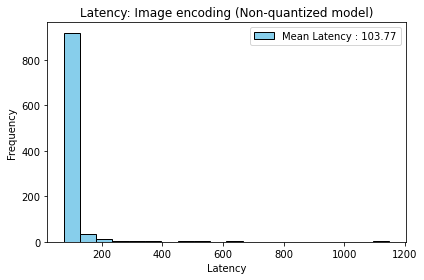

In [102]:
plot_latency(processed_im_non_quantized_data['df'], 'Latency: Image encoding (Non-quantized model)')

### Correlation

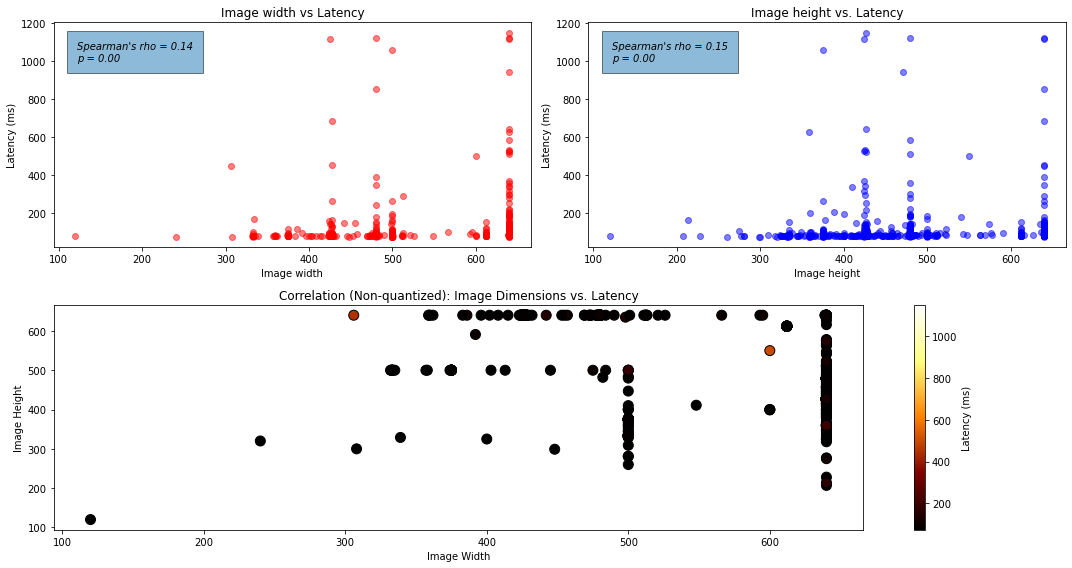

In [139]:
plot_img_latency_correlation(**processed_im_non_quantized_data, title='Correlation (Non-quantized): Image Dimensions vs. Latency')

## Analysis Image encoding using a quantized model

In [68]:
processed_img_quantized_data=process_img_latency_data(img_quantized)

            img_w        img_h      latency
count  1000.00000  1000.000000  1000.000000
mean    575.98900   487.819000    82.455210
std      91.88521    98.353819    90.330740
min     120.00000   120.000000    55.470617
25%     500.00000   427.000000    61.642906
50%     640.00000   480.000000    63.417372
75%     640.00000   612.000000    66.954997
max     640.00000   640.000000   896.805574

Spearmans correlation coefficient between width and latency: 
 Statistic: 0.13218981217709 
 p-value: 2.7480980110562765e-05
Spearmans correlation coefficient between height and Latency: 
 Statistic: 0.18535183706213584 
 p-value: 3.5211221632502458e-09


### Latency

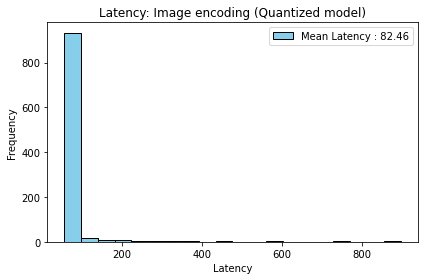

In [110]:
plot_latency(processed_img_quantized_data['df'], 'Latency: Image encoding (Quantized model)')

### Correlation

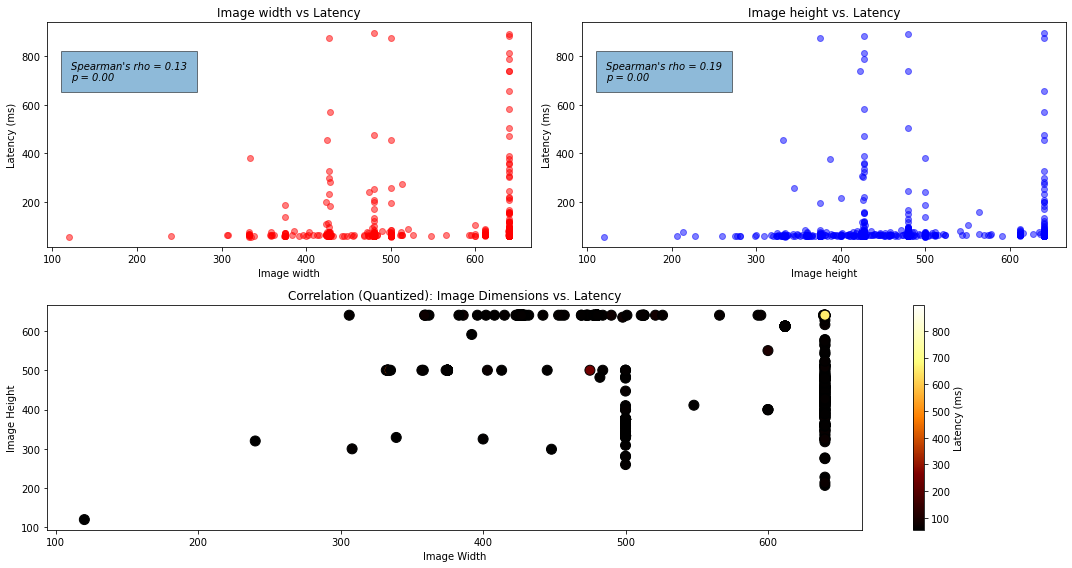

In [118]:
plot_img_latency_correlation(**processed_img_quantized_data, title='Correlation (Quantized): Image Dimensions vs. Latency')

### Image encoding: Latency comparison


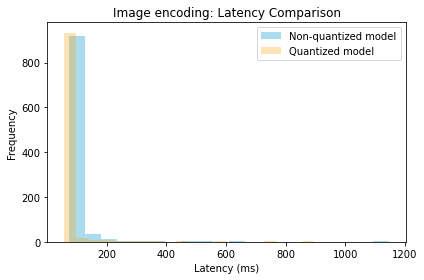

In [113]:
comparison_non_quant_non_quant_model(processed_im_non_quantized_data,processed_img_quantized_data, 'Image encoding: Latency Comparison')

# Analysis of latencies for the generation of text/query encodings

### Analysis of latencies for the generation of text encodings given a non-quantized model

In [80]:
processed_text_data_non_quantized = proces_text_latency_data(text_non_quantized)

       text_length      latency
count  1000.000000  1000.000000
mean     10.453000    35.024421
std       2.313686    48.013523
min       7.000000    16.555792
25%       9.000000    18.795178
50%      10.000000    20.417353
75%      11.000000    24.886927
max      26.000000   288.841596

Spearmans correlation coefficient between the text length and the latency: 
 Statistic: 0.23878480264667373
 p-value: 1.9701880876721238e-14


### Latency

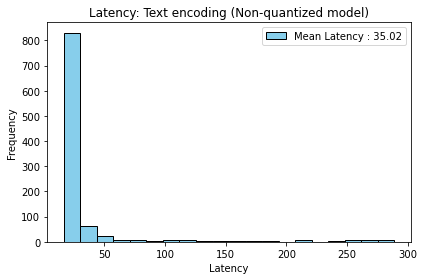

In [114]:
plot_latency(processed_text_data_non_quantized['df'], 'Latency: Text encoding (Non-quantized model)')

### Correlation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


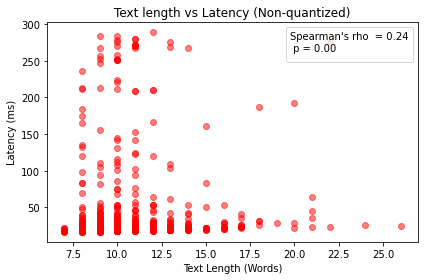

In [120]:
plot_text_latency_data(**processed_text_data_non_quantized, title= 'Text length vs Latency (Non-quantized)')

### Analysis of latencies for the generation of text encodings given a quantized model

In [82]:
processed_text_data_quantized = proces_text_latency_data(text_quantized)

       text_length      latency
count  1000.000000  1000.000000
mean     10.453000    20.673455
std       2.313686    32.278959
min       7.000000    11.311798
25%       9.000000    13.080365
50%      10.000000    13.948404
75%      11.000000    15.483770
max      26.000000   276.742988

Spearmans correlation coefficient between the text length and the latency: 
 Statistic: 0.4228573217582712
 p-value: 1.2076112765953767e-44


### Latency

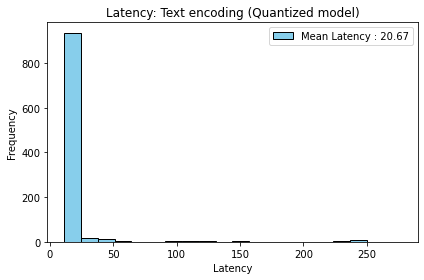

In [121]:
plot_latency(processed_text_data_quantized['df'], 'Latency: Text encoding (Quantized model)')

### Corrleation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


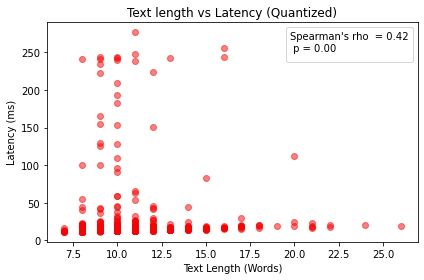

In [122]:
plot_text_latency_data(**processed_text_data_quantized, title= 'Text length vs Latency (Quantized)')

### Text encoding: Latency comparison

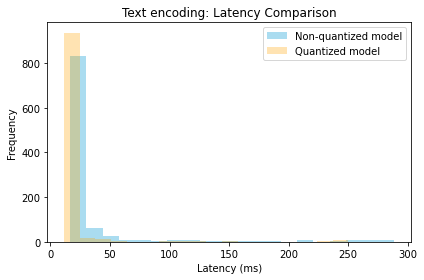

In [123]:
comparison_non_quant_non_quant_model(processed_text_data_non_quantized,processed_text_data_quantized, 'Text encoding: Latency Comparison')

## Analysis of the search pipeline latency

### Latency given a non-quantized model.

In [131]:
df_search_non_quantized = pd.DataFrame({'latency':[l*1000 for l in search_non_quantized]})
df_search_non_quantized.describe()

,latency
count,1000.000000
mean,816.023360
std,79.632925
min,758.685847
25%,774.550775
50%,782.736782
75%,813.003917
max,1425.933107


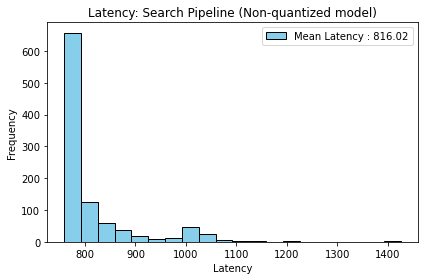

In [128]:
plot_latency(df_search_non_quantized, 'Latency: Search Pipeline (Non-quantized model)')

### Latency given a quantized model.

In [134]:
df_search_quantized = pd.DataFrame({'latency':[l*1000 for l in search_quantized]})
df_search_quantized.describe()

,latency
count,1000.000000
mean,815.367245
std,75.375312
min,760.686142
25%,776.402715
50%,784.679765
75%,806.153755
max,1188.648071


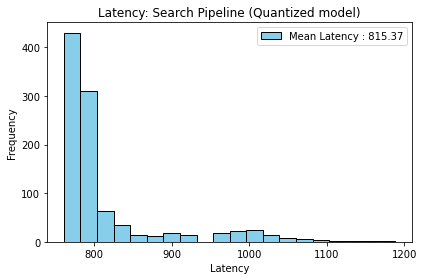

In [135]:
plot_latency(df_search_quantized, 'Latency: Search Pipeline (Quantized model)')

### Search pipeline: Latency Comparison

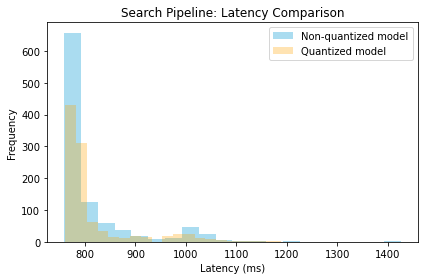

In [136]:
comparison_non_quant_non_quant_model({'df':df_search_non_quantized},
                                     {'df':df_search_quantized},
                                     'Search Pipeline: Latency Comparison')
